In [1]:
%matplotlib inline

In [2]:
!pip install numpy binance-connector

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta, UTC
import requests
import json
from binance.spot import Spot
from binance_secrets import api_key, api_secret
from typing import Dict, List

In [4]:
spot_client = Spot(api_key, api_secret)

In [6]:
# Check whether we can get next hour's interest rate
spot_client.get_a_future_hourly_interest_rate(assets=["USDT", "BTC"], isIsolated=True)

[{'asset': 'BTC', 'nextHourlyInterestRate': '0.00000138'},
 {'asset': 'USDT', 'nextHourlyInterestRate': '0.00004004'}]

In [8]:
def get_interest_history(asset: str, vipLevel: int, startTime: datetime, endTime: datetime, size: int = 90) -> Dict:
    """Get historical interest rates
    """
    return json.loads(
        requests.get(
            "https://www.binance.com/bapi/margin/v1/public/margin/vip/spec/history-interest-rate",
            params={
                "asset": asset,
                "vipLevel": vipLevel,
                "size": size,
                "startTime": int(startTime.timestamp() * 1000), # Convert to timestamp in ms
                "endTime": int(endTime.timestamp() * 1000), # Convert to timestamp in ms
            }
        ).content
    )

In [12]:
def get_month_list(start_date: datetime, end_date: datetime) -> List[datetime]:
    dates = []
    _ = start_date
    while _ < end_date:
        dates.append(_)
        _ += pd.DateOffset(months=1)
    dates.append(end_date)
    return dates

In [18]:
def get_asset_hourly_interest_rate_series(asset: str, start_date: datetime, end_date: datetime) -> pd.Series:
    """Get a series of historical hoursly interest rates of an asset. The
    series returned will be renamed to the name of the asset
    """
    df_rates = []
    dates = get_month_list(start_date, end_date)
    for start, next_start in zip(dates[:-1], dates[1:]):
        _ = pd.DataFrame(
            get_interest_history(
                asset=asset,
                vipLevel=0,
                startTime=start,
                endTime=next_start + timedelta(hours=-1)
            )["data"]
        )
        _["dailyInterestRate"] = pd.to_numeric(_["dailyInterestRate"])
        _["datetime"] = _["timestamp"].apply(
            lambda x: datetime.utcfromtimestamp(int(x) / 1000)
        )
        df_rates.append(_)
    df_rates = pd.concat(df_rates)
    df_rates = df_rates.set_index("datetime").sort_index()
    df_rates = df_rates.drop_duplicates()

    # dates without changes in interest rate may not show up in interest rate
    # history need to reindex the dataframe and fill it with previously seen
    # data points
    
    start = df_rates.index[0]
    end = df_rates.index[-1]
    new_dates = pd.date_range(start=start, end=end, freq="H")
    
    df_rates = df_rates.reindex(new_dates)

    return df_rates["dailyInterestRate"].ffill().rename(asset)

In [40]:
start_date = datetime(2023, 3, 1)
end_date = datetime(2023, 12, 20)

In [41]:
df_rates = pd.concat(
    (
        get_asset_hourly_interest_rate_series(
            "USDT",
            start_date=start_date,
            end_date=end_date
        ),
        get_asset_hourly_interest_rate_series(
            "BTC",
            start_date=start_date,
            end_date=end_date
        )
    ),
    axis=1
).ffill()

/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_68735/3270455035.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  lambda x: datetime.utcfromtimestamp(int(x) / 1000)
/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_68735/3270455035.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  lambda x: datetime.utcfromtimestamp(int(x) / 1000)
/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_68735/3270455035.py:18: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: d

In [42]:
df_rates["USDT_pct_change"] = df_rates["USDT"].pct_change()
df_rates["BTC_pct_change"] = df_rates["BTC"].pct_change()

In [43]:
df_rates

,USDT,BTC,USDT_pct_change,BTC_pct_change
2023-03-01 00:00:00,0.000256,0.000110,NaN,NaN
2023-03-01 01:00:00,0.000256,0.000110,0.000000,0.0
2023-03-01 02:00:00,0.000256,0.000110,0.000000,0.0
2023-03-01 03:00:00,0.000256,0.000110,0.000000,0.0
2023-03-01 04:00:00,0.000256,0.000110,0.000000,0.0
...,...,...,...,...
2023-12-19 18:00:00,0.000847,0.000033,0.018154,0.0
2023-12-19 19:00:00,0.000847,0.000033,0.000000,0.0
2023-12-19 20:00:00,0.000812,0.000033,-0.041458,0.0
2023-12-19 21:00:00,0.000812,0.000033,0.000000,0.0


In [44]:
df_rates[["USDT", "BTC", "USDT_pct_change", "BTC_pct_change"]].corr()

,USDT,BTC,USDT_pct_change,BTC_pct_change
USDT,1.000000,-0.224228,0.053056,0.003375
BTC,-0.224228,1.000000,-0.009528,0.010219
USDT_pct_change,0.053056,-0.009528,1.000000,0.052338
BTC_pct_change,0.003375,0.010219,0.052338,1.000000


<Axes: xlabel='USDT', ylabel='BTC'>

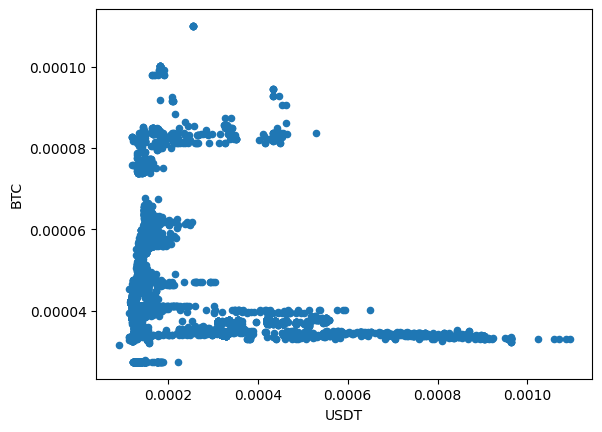

In [45]:
df_rates[["USDT", "BTC"]].plot(x="USDT", y="BTC", kind="scatter")

In [46]:
def get_price_history(symbol, interval, startTime, endTime):
    return spot_client.klines(
        symbol=symbol,
        interval=interval,
        startTime=int(startTime.timestamp() * 1000), # Convert to timestamp in ms
        endTime=int(endTime.timestamp() * 1000), # Convert to timestamp in ms
        limit=1000
    )

In [47]:
def get_asset_hourly_ohlc(asset: str, start_date: datetime, end_date: datetime) -> pd.DataFrame:
    dates = get_month_list(start_date, end_date)
    df_price = []
    for start, next_start in zip(dates[:-1], dates[1:]):
        _ = pd.DataFrame(
            get_price_history(
                symbol='BTCUSDT',
                interval="1h",
                startTime=start,
                endTime=next_start + timedelta(hours=-1)
            ),
            columns=[
                "date",
                "open", 
                "high",
                "low",
                "close",
                "volume",
                "close_time",
                "quote_value",
                "n_trades",
                "taker_buy_base",
                "taker_buy_quote",
                "_"
            ],
            dtype=float
        )
        _["date"] = _["date"].apply(lambda x: datetime.utcfromtimestamp(int(x) / 1000))
        _["close_time"] = _["close_time"].apply(lambda _: datetime.utcfromtimestamp(_/1000))
        df_price.append(_)
    df_price = pd.concat(df_price)
    df_price = df_price.set_index("date").sort_index()
    df_price = df_price.drop_duplicates()

    return df_price

In [48]:
df_price = get_asset_hourly_ohlc("BTCUSDT", start_date=start_date, end_date=end_date)

/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_68735/377979687.py:28: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _["date"] = _["date"].apply(lambda x: datetime.utcfromtimestamp(int(x) / 1000))
/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_68735/377979687.py:29: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  _["close_time"] = _["close_time"].apply(lambda _: datetime.utcfromtimestamp(_/1000))
/var/folders/xf/cyn6bbj5137_wg7d37wflh5r0000gq/T/ipykernel_68735/377979687.py:28: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version.

In [49]:
df_price.head()

,open,high,low,close,volume,close_time,quote_value,n_trades,taker_buy_base,taker_buy_quote,_
date,,,,,,,,,,,
2023-03-01 00:00:00,23141.57,23219.99,23020.03,23101.00,12736.94918,2023-03-01 00:59:59.999,2.946088e+08,430193.0,6319.19996,1.461616e+08,0.0
2023-03-01 01:00:00,23101.00,23296.94,23075.14,23245.96,11574.17720,2023-03-01 01:59:59.999,2.684089e+08,406084.0,5870.16685,1.361318e+08,0.0
2023-03-01 02:00:00,23245.96,23336.46,23234.20,23331.21,7905.82139,2023-03-01 02:59:59.999,1.840239e+08,347380.0,4005.83436,9.324660e+07,0.0
2023-03-01 03:00:00,23332.57,23498.00,23305.97,23441.14,14946.69431,2023-03-01 03:59:59.999,3.500738e+08,475232.0,7761.09682,1.817791e+08,0.0
2023-03-01 04:00:00,23440.37,23847.00,23425.44,23794.48,15445.26401,2023-03-01 04:59:59.999,3.647411e+08,492077.0,8443.33167,1.994118e+08,0.0


In [50]:
df_price["close_pct_change"] = df_price["close"].pct_change()

In [51]:
df_price["close_pct_change_sign"] = df_price["close_pct_change"].apply(np.sign)

In [52]:
df_price.head()

,open,high,low,close,volume,close_time,quote_value,n_trades,taker_buy_base,taker_buy_quote,_,close_pct_change,close_pct_change_sign
date,,,,,,,,,,,,,
2023-03-01 00:00:00,23141.57,23219.99,23020.03,23101.00,12736.94918,2023-03-01 00:59:59.999,2.946088e+08,430193.0,6319.19996,1.461616e+08,0.0,NaN,NaN
2023-03-01 01:00:00,23101.00,23296.94,23075.14,23245.96,11574.17720,2023-03-01 01:59:59.999,2.684089e+08,406084.0,5870.16685,1.361318e+08,0.0,0.006275,1.0
2023-03-01 02:00:00,23245.96,23336.46,23234.20,23331.21,7905.82139,2023-03-01 02:59:59.999,1.840239e+08,347380.0,4005.83436,9.324660e+07,0.0,0.003667,1.0
2023-03-01 03:00:00,23332.57,23498.00,23305.97,23441.14,14946.69431,2023-03-01 03:59:59.999,3.500738e+08,475232.0,7761.09682,1.817791e+08,0.0,0.004712,1.0
2023-03-01 04:00:00,23440.37,23847.00,23425.44,23794.48,15445.26401,2023-03-01 04:59:59.999,3.647411e+08,492077.0,8443.33167,1.994118e+08,0.0,0.015073,1.0


In [53]:
df_combined = df_rates.join(df_price)[list(df_rates.columns) + ["open", "high", "low", "close", "close_pct_change", "close_pct_change_sign"]]
df_combined.index.name = "Date"

In [54]:
df_combined.dropna()

,USDT,BTC,USDT_pct_change,BTC_pct_change,open,high,low,close,close_pct_change,close_pct_change_sign
Date,,,,,,,,,,
2023-03-01 01:00:00,0.000256,0.000110,0.000000,0.0,23101.00,23296.94,23075.14,23245.96,0.006275,1.0
2023-03-01 02:00:00,0.000256,0.000110,0.000000,0.0,23245.96,23336.46,23234.20,23331.21,0.003667,1.0
2023-03-01 03:00:00,0.000256,0.000110,0.000000,0.0,23332.57,23498.00,23305.97,23441.14,0.004712,1.0
2023-03-01 04:00:00,0.000256,0.000110,0.000000,0.0,23440.37,23847.00,23425.44,23794.48,0.015073,1.0
2023-03-01 05:00:00,0.000256,0.000110,0.000000,0.0,23794.48,23821.56,23631.97,23694.17,-0.004216,-1.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-19 18:00:00,0.000847,0.000033,0.018154,0.0,41854.07,42236.59,41811.10,42216.41,0.008657,1.0
2023-12-19 19:00:00,0.000847,0.000033,0.000000,0.0,42216.41,42482.20,42148.88,42341.96,0.002974,1.0
2023-12-19 20:00:00,0.000812,0.000033,-0.041458,0.0,42341.96,42394.83,42121.12,42228.15,-0.002688,-1.0


In [55]:
df_combined[["USDT", "BTC", "USDT_pct_change", "BTC_pct_change", "close_pct_change"]].corr()

,USDT,BTC,USDT_pct_change,BTC_pct_change,close_pct_change
USDT,1.000000,-0.224228,0.053056,0.003375,-0.000597
BTC,-0.224228,1.000000,-0.009528,0.010219,0.004705
USDT_pct_change,0.053056,-0.009528,1.000000,0.052338,-0.013590
BTC_pct_change,0.003375,0.010219,0.052338,1.000000,-0.001243
close_pct_change,-0.000597,0.004705,-0.013590,-0.001243,1.000000


In [56]:
df_combined.to_csv("df_combined_hourly.csv")